# Notebook to train a ML model to learn barriers

## Initial setup: Generation of amorphous 2D lattice and strucuture optimizations to compute grafting barriers

In [8]:
# Standard libraries
import json
import matplotlib
# pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.integrate as integrate
import seaborn as sns
from matplotlib import animation
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import matplotlib.ticker as ticker

# non-pip
from potentials import *
from visualization import *
from lattice import *
from il import *
from il_pedagogical import *




# set lattice size (the lattice size will be lattice_size*lattice_size). To get ~ 20000 sites choose lattice_size=1500
lattice_size = 1500
# temperature
T = 298.15
# covariance of random perturbations to lattice to generate disorder
cov = 0.00022
displacement_type = 'normal'
disp_kwargs = {'covariance' : [[cov, 0], [0, cov]]}


# fraction of empty, OH, and siloxane sites
empty_fraction = 0.3
OH_fraction = 0.3
siloxane_fraction = 0.4



# Morse potential constants for reaction (see "Grafting metal complexes onto amorphous supports: from elementary steps to catalyst site populations via kernel regression" for details)
D_MO = 524.4
r_eq_MO = 1.
a_MO = 1.9

D_M_O = 120.
r_eq_M_O = 1.16
a_M_O = 2.3

E_MA = 160.

MO_Morse = {'D' : D_MO, 'a' : a_MO, 'r_eq' : r_eq_MO}
siloxane_Morse = {'D' : D_M_O, 'a' : a_M_O, 'r_eq' : r_eq_M_O}
lattice_fractions = {'empty' : empty_fraction, 'OH' : OH_fraction, 'Siloxane' : siloxane_fraction}


# generate lattice
lattice = make_quenched_disorder_lattice(lattice_size, cov, True, False)
decorated_lattice = decorate_lattice(lattice, empty_fraction, OH_fraction, siloxane_fraction)

# find sites that can graft
graftable_sites, competing_sites = locate_grafting_sites(decorated_lattice)

# local coordinates to define local site environment
local_coordinates = compute_local_coordinates(decorated_lattice, graftable_sites)
local_coordinates = local_coordinates[:,0:3]
local_coordinates_dict = {'OH-OH-distance' : local_coordinates[:, 0],
                            'siloxane-distances' : local_coordinates[:, 1],
                            'OH-siloxane-angle' : local_coordinates[:, 2]}



# calculate grafting free energy barriers
graft_E, ads_E = grafting_energies(MO_Morse, siloxane_Morse, E_MA, T, graftable_sites, decorated_lattice)
graft_E_non_d = 0.5*graft_E
#offset by 131.3 just for plotting purposes
graft_E = 131.3+0.5*graft_E




## Calculate evolving population of sites and evolving total surface sites

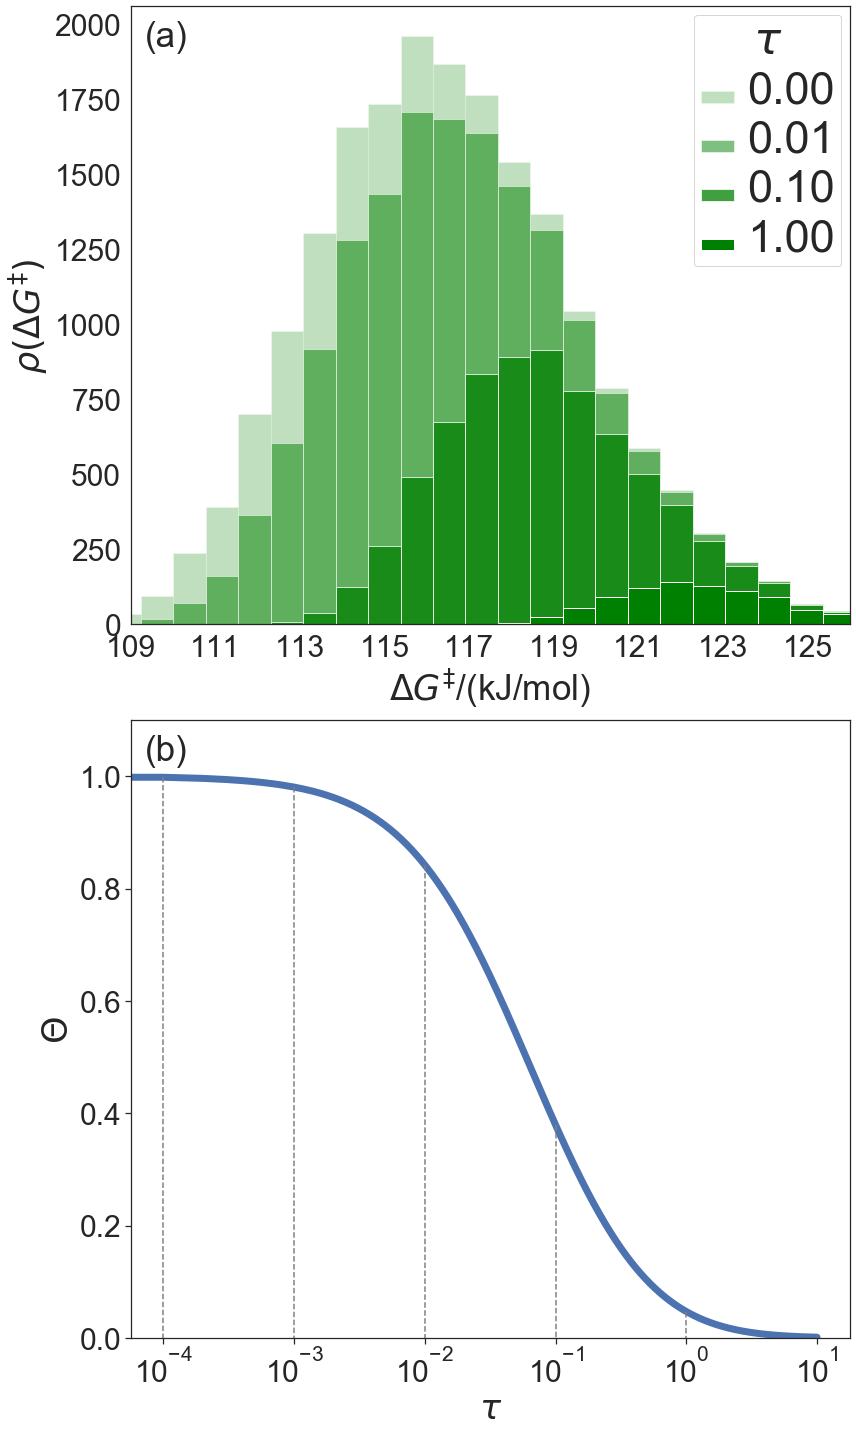

In [11]:
# calculate the time evolution of the reaction of sites and plot
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# choose number of bins to plot grafting barrier distribution
n_bins = 30
hist_data, bin_edges = np.histogram(graft_E, bins = n_bins)

# times at which evolving population should be plot
time = [0, 0.01, 0.1, 1]
hist_data_final = hist_data
bin_edges_final = bin_edges
mid_hist = np.asarray([(bin_edges[i]+bin_edges[i+1])/2 for i in range(np.shape(bin_edges)[0]-1)])
lattice_len = int(np.sqrt(len(graft_E)) + 2)
n_sites = np.shape(graft_E)[0]
wid = mid_hist[2] - mid_hist[1]

axes[0].set_xlim((109, 126))

# plot evolving population
for counter, i in enumerate(time):
    h_mod = histogram_graft_mod_non_dim(hist_data, bin_edges, i, T)

    if counter == 0:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.00", color = 'green')
    elif counter == 1:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.01", color = 'green')
    elif counter == 2:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.10", color = 'green')
    elif counter == 3:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "1.00", color = 'green')

        

props = dict(boxstyle='round', facecolor='white', alpha=0.0)

# axes properties
axes[0].set_xlabel(r'$\Delta G^{\ddag}$/(kJ/mol)',fontsize = 35)
axes[0].set_ylabel(r'$\rho(\Delta G^{\ddag})$',fontsize = 35)
axes[0].set_xlim(109, 126) 
axes[0].xaxis.set_ticks(np.arange(109, 126, 2))
axes[0].tick_params(axis = "x", labelsize = 30)
axes[0].tick_params(axis = "y", labelsize = 30)



# set legend
leg1 = axes[0].legend(title=r'$\tau$')
plt.setp(leg1.get_title(), fontsize = 45)
plt.setp(leg1.get_texts(), fontsize = 45)


# make second plot with evolcing total vicinal site population
time = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
time = np.linspace(0,10,100000)
left_silanols = np.zeros(np.shape(time)[0])


# plot
for counter, i in enumerate(time):
    left_silanols[counter]= np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, i, T))/(np.shape(graft_E)[0])

# label axes
axes[1].set_xlabel(r'$\tau$',fontsize = 35)
axes[1].set_ylabel(r"$\Theta$",fontsize = 35)
axes[1].plot(time, left_silanols, linewidth = 7.0)



# add grid lines
axes[1].plot([0.0001, 0.0001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.0001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.001, 0.001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.01, 0.01],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.01, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.1, 0.1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([1, 1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([10.0, 10.0],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 10.0, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')

axes[1].tick_params(left='true', bottom='true')


# add a and b labels to image
anchored_text1 = AnchoredText("(a)", borderpad=0., loc=2,frameon=False,prop=dict(fontsize=35))
anchored_text2 = AnchoredText("(b)", borderpad=0., loc=2,frameon=False,prop=dict(fontsize=35))
axes[0].add_artist(anchored_text1)
axes[1].add_artist(anchored_text2)


#set axes limits
axes[1].set_ylim([0, 1.1])
#set log scale
axes[1].set_xscale('log')
# label size
axes[1].tick_params(axis = "x", labelsize = 30)
axes[1].tick_params(axis = "y", labelsize = 30)



plt.tight_layout()
plt.show()




## Train a metric learning model to predict grafting barriers using a small training set

c:\users\salman\appdata\local\programs\python\python37\lib\site-packages\metric_learn\mlkr.py:181: ChangedBehaviorWarning: Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of 'pca'. If you still want to use PCA as an init, set init='pca'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.
  warnings.warn(msg, ChangedBehaviorWarning)


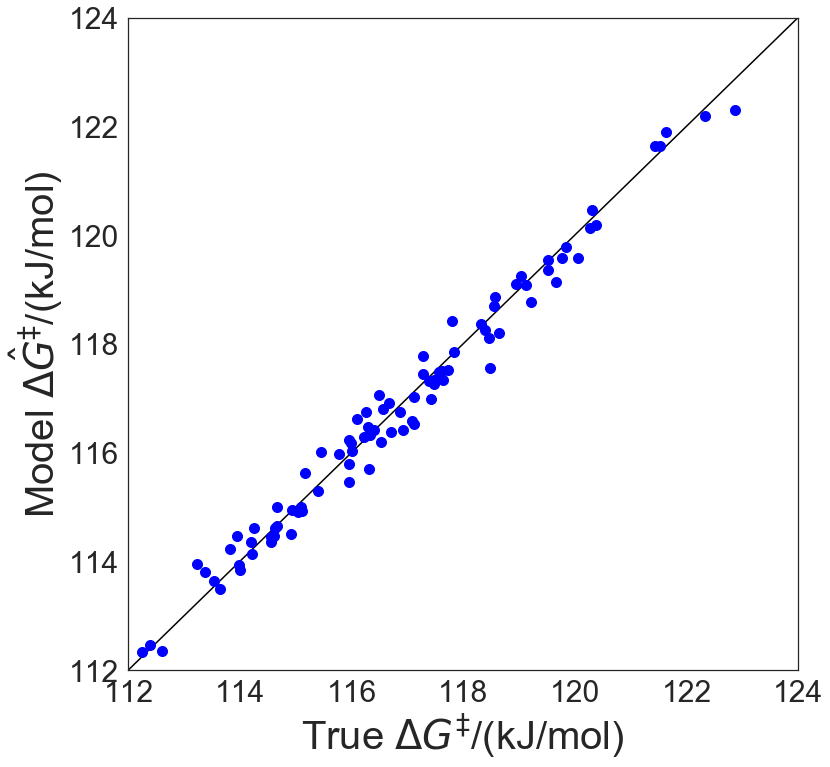

In [3]:
# randomly sample some sites from the total and learn their grafting barriers as a function of the local environment

# number of samples
n_samples=100
sampled_sites, rand_state = sample_sites(graft_E, n_samples, 484, False)
sampled_heights = graft_E[sampled_sites]
sampled_coordinates = local_coordinates[sampled_sites]
sampled_barrier_heights = sampled_heights[0:100]
sampled_local_coordinates = sampled_coordinates[0:100]


# train and return the Mahalanobis matrix and model predicted barriers
M, model_barriers_LOO, residuals = train(sampled_local_coordinates, sampled_barrier_heights)

# plot traning
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

plot_trained(ax, 10, model_barriers_LOO, sampled_barrier_heights, 2.5, 100)
ax.set_xlabel(r'True $\Delta G^{\ddag}$/(kJ/mol)', fontsize = 40)
ax.set_ylabel(r'Model $\Delta \^G^{\ddag}$/(kJ/mol)', fontsize = 40)
ax.tick_params(axis = "x", labelsize = 30)
ax.tick_params(axis = "y", labelsize = 30)

ax.set_xlim([112,124])
ax.set_ylim([112,124])
plt.show()


## Performance of ML model on the test set (all sites)

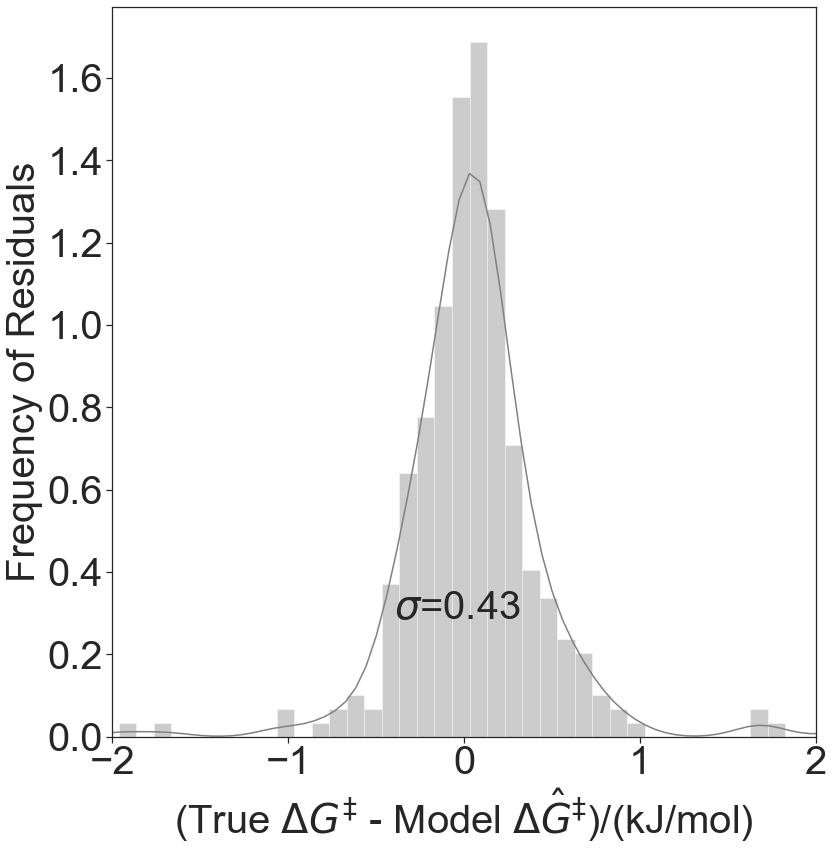

In [4]:
# predict grafting barriers fo all sites using ML model trained on a small set of sites



# predict barriers
model_barrier_heights = predicted_adsorption_energies(sampled_local_coordinates, sampled_barrier_heights, M, local_coordinates,np.shape(graft_E)[0]) 


# errors made by machine learning model
residuals = graft_E - model_barrier_heights


# plot the residuals
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
sns.distplot(residuals, bins=50, color="grey")
ax.set_xlabel(r'(True ${\Delta}G^{\ddag}$ - Model ${\Delta}\^G^{\ddag}$)/(kJ/mol)', fontsize = 40)
ax.set_ylabel('Frequency of Residuals', fontsize = 40)
ax.tick_params(axis = "x", labelsize = 40)
ax.tick_params(axis = "y", labelsize = 40)
ax.set_xlim([-2,2])
textstr = '$\sigma$='+str(round(np.sqrt(np.var(graft_E-model_barrier_heights)),2))
props = dict(boxstyle='round', facecolor='white', alpha=0.0)

ax.text(0.4, 0.2, textstr, transform=ax.transAxes, fontsize=40,
        verticalalignment='top', bbox=props)

ax.tick_params(left='true', bottom='true')
plt.tight_layout()
plt.show()

## Errors on the test set as a function of training set size

c:\users\salman\appdata\local\programs\python\python37\lib\site-packages\metric_learn\mlkr.py:181: ChangedBehaviorWarning: Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of 'pca'. If you still want to use PCA as an init, set init='pca'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.
  warnings.warn(msg, ChangedBehaviorWarning)
c:\users\salman\appdata\local\programs\python\python37\lib\site-packages\metric_learn\mlkr.py:181: ChangedBehaviorWarning: Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of 'pca'. If you still want to use PCA as an init, set init='pca'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.
  warnings.warn(msg, ChangedBehaviorWarning)
c:\users\salman\appdata\local\programs\python\python37\lib\site-packages\metric_learn\mlkr.py:181: Changed

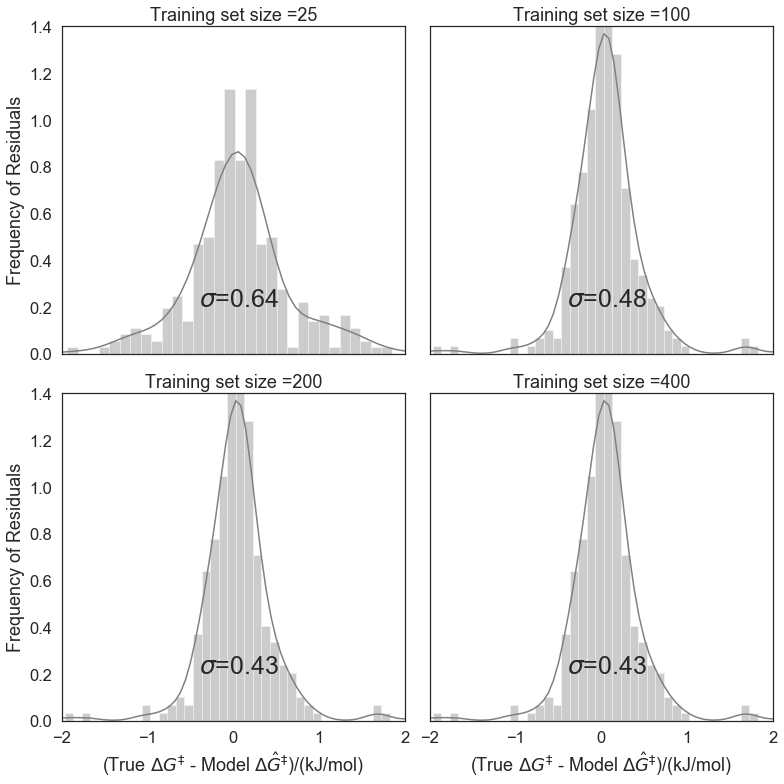

In [5]:
# residulas as a function of training set size

# array containing number of samples 
n_samples=[25, 100, 200, 400]




plt.rcParams['figure.figsize'] = 11, 11
fig = plt.figure()


for i, l in enumerate(n_samples):    
    # train model with different sample size
    sampled_barrier_heights = sampled_heights[0:l]
    sampled_local_coordinates = sampled_coordinates[0:l]
    ax = fig.add_subplot(2, 2, i+1)
    M, model_barriers_LOO, residuals = train(sampled_local_coordinates, sampled_barrier_heights)
    model_barrier_heights = predicted_adsorption_energies(sampled_local_coordinates, sampled_barrier_heights, M, local_coordinates,np.shape(graft_E)[0]) 
    
    
    # calculate residuals
    residuals = graft_E - model_barrier_heights

    # plot residuals
    sns.distplot(residuals, bins=50, color="grey")
    
    if i == 0 or i == 2:
        ax.set_ylabel('Frequency of Residuals')
    if i == 2 or i == 3:
        ax.set_xlabel(r'(True ${\Delta}G^{\ddag}$ - Model ${\Delta}\^G^{\ddag}$)/(kJ/mol)')
    
    ax.set_xlim([-2,2])
    ax.set_ylim([0,1.4])   
    ax.set_title('Training set size ='+str(l))
    if i == 0 or i == 1:
        ax.set_xticklabels([])
    if i == 1 or i == 3:
        ax.set_yticklabels([])
    
    if i == 1:
        textstr = '$\sigma$=0.48'
    else:
        textstr = '$\sigma$='+str(round(np.sqrt(np.var(graft_E-model_barrier_heights)),2))

    props = dict(boxstyle='round', facecolor='white', alpha=0.0)

    ax.text(0.4, 0.2, textstr, transform=ax.transAxes, fontsize=25,
            verticalalignment='top', bbox=props)


plt.tight_layout()
plt.show()

## Evolving population of sites and evolving total surface sites as predicted by the ML model

c:\users\salman\appdata\local\programs\python\python37\lib\site-packages\metric_learn\mlkr.py:181: ChangedBehaviorWarning: Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of 'pca'. If you still want to use PCA as an init, set init='pca'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.
  warnings.warn(msg, ChangedBehaviorWarning)
No handles with labels found to put in legend.


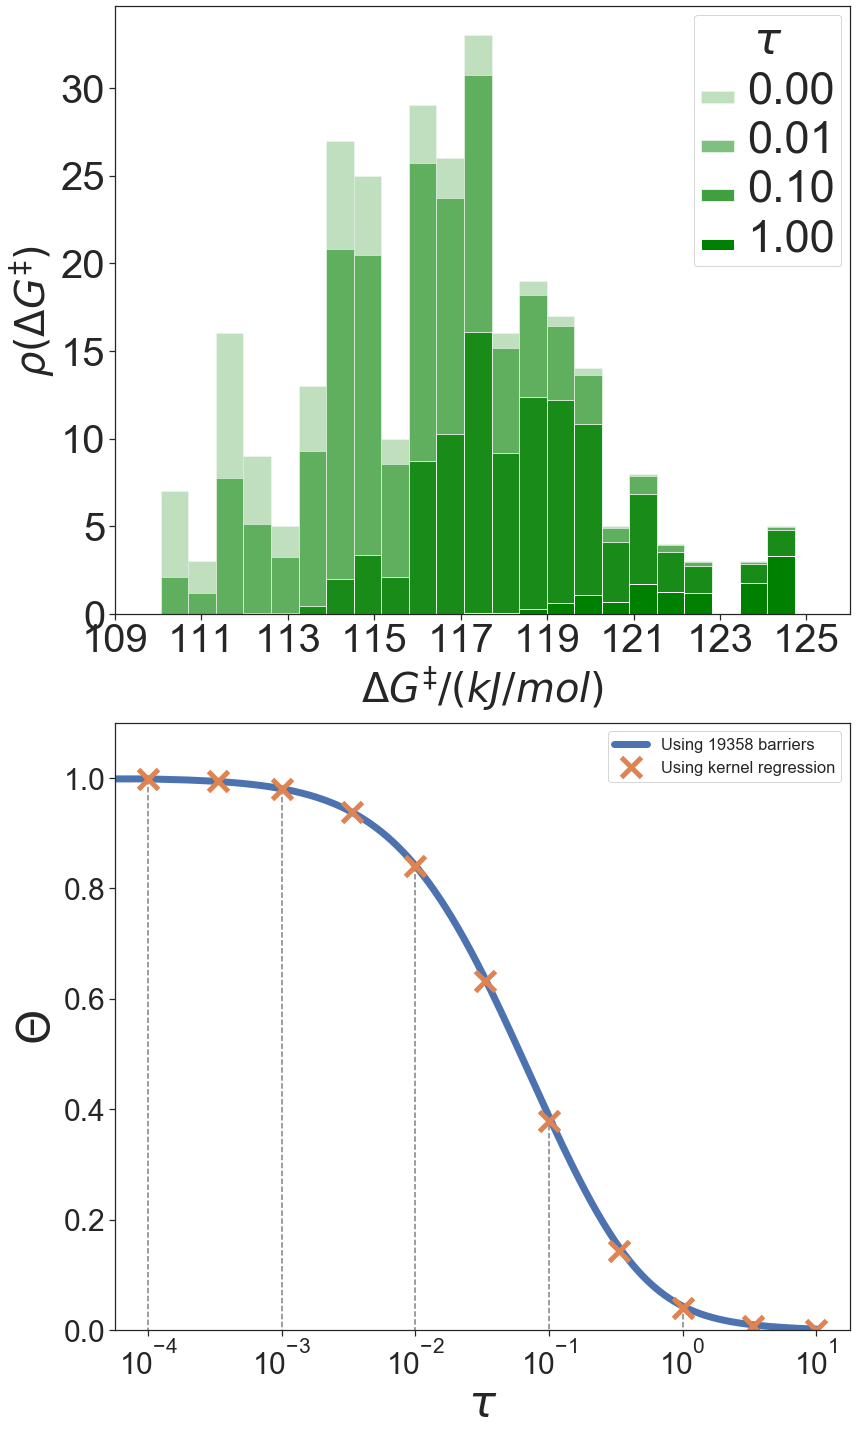

In [6]:
# predicting the evolving population using the ML model


# times at which population should be plotted
time = [0, 0.01, 0.1, 1]

# number of bins to plot population plots
n_bins = 30

# number of samples
n_samples = 100


# trained model 
M, model_barriers_LOO, residuals = train(sampled_coordinates[0:n_samples,0:2], sampled_heights[0:n_samples])
model_heights = predicted_adsorption_energies(sampled_coordinates[0:n_samples,0:2], sampled_heights[0:n_samples], M, local_coordinates[:,0:2],np.shape(graft_E)[0]) 

# predicted histogram
hist_data_predicted, bin_edges_predicted = np.histogram(model_heights, bins = bin_edges_final)
mid_hist_predicted = np.asarray([(bin_edges_predicted[i]+bin_edges_predicted[i+1])/2 for i in range(np.shape(bin_edges)[0]-1)])
wid = mid_hist_predicted[2]-mid_hist_predicted[1]
mid_hist_final = np.asarray([(bin_edges_final[i]+bin_edges_final[i+1])/2 for i in range(np.shape(bin_edges_final)[0]-1)])
wid_final = mid_hist_final[2]-mid_hist_final[1]


# plot evolving population
fig, axes = plt.subplots(2, 1, figsize=(12, 20))
for counter, i in enumerate(time):
    h_mod = histogram_graft_mod_non_dim(hist_data_predicted, bin_edges_final, i, T)   
    if counter == 0:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.00", color = 'green')
    elif counter == 1:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.01", color = 'green')
    elif counter == 2:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.10", color = 'green')
    elif counter == 3:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "1.00", color = 'green')
        

# axes properties        
axes[0].set_xlim((109, 126))
axes[0].set_ylabel(r'$\rho(\Delta G^{\ddag})$', fontsize = 40)
axes[0].set_xlabel(r'$\Delta G^{\ddag}/(kJ/mol)$', fontsize = 40)
axes[0].xaxis.set_ticks(np.arange(109, 126, 2))
axes[0].tick_params(left='true', bottom='true')

axes[0].tick_params(axis = "x", labelsize = 40)
axes[0].tick_params(axis = "y", labelsize = 40)
        
leg1 = axes[0].legend(title=r'$\tau$')

plt.setp(leg1.get_title(), fontsize = 45)
plt.setp(leg1.get_texts(), fontsize = 45)



# make second plot with evolcing total vicinal site population

time = np.linspace(0,10,100000)
time_pred = [0.0001, 0.0003333, 0.001, 0.003333, 0.01, 0.03333, 0.1, 0.3333, 1.0, 3.333, 10.0]
left_silanols_predicted = np.zeros(np.shape(time_pred)[0])


for counter, i in enumerate(time_pred):
    left_silanols_predicted[counter]= np.sum(histogram_graft_mod_non_dim(hist_data_predicted, bin_edges, i, T))/(np.shape(graft_E)[0])




# adding grid lines
axes[1].plot([0.0001, 0.0001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.0001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.001, 0.001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.01, 0.01],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.01, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.1, 0.1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([1, 1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([10.0, 10.0],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 10.0, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')

# axes properties
axes[1].tick_params(left='true', bottom='true')
axes[1].legend( prop={'size':  25})
axes[1].tick_params(left='true')
axes[1].set_ylim([0, 1.1])
axes[1].set_xscale('log')
axes[1].tick_params(axis = "x", labelsize = 30)
axes[1].tick_params(axis = "y", labelsize = 30)
axes[1].set_xlabel(r'$\tau$',fontsize = 45)
axes[1].set_ylabel(r"$\Theta$",fontsize = 45)
axes[1].plot(time, left_silanols, label = 'Using 19358 barriers', linewidth = 7.0)
axes[1].plot(time_pred, left_silanols_predicted, 'x', label = 'Using kernel regression', markersize=20, markeredgewidth=5)
leg = plt.legend()



plt.tight_layout()

plt.show()


## Plot predicted grafting barriers as a function of important local coordinates

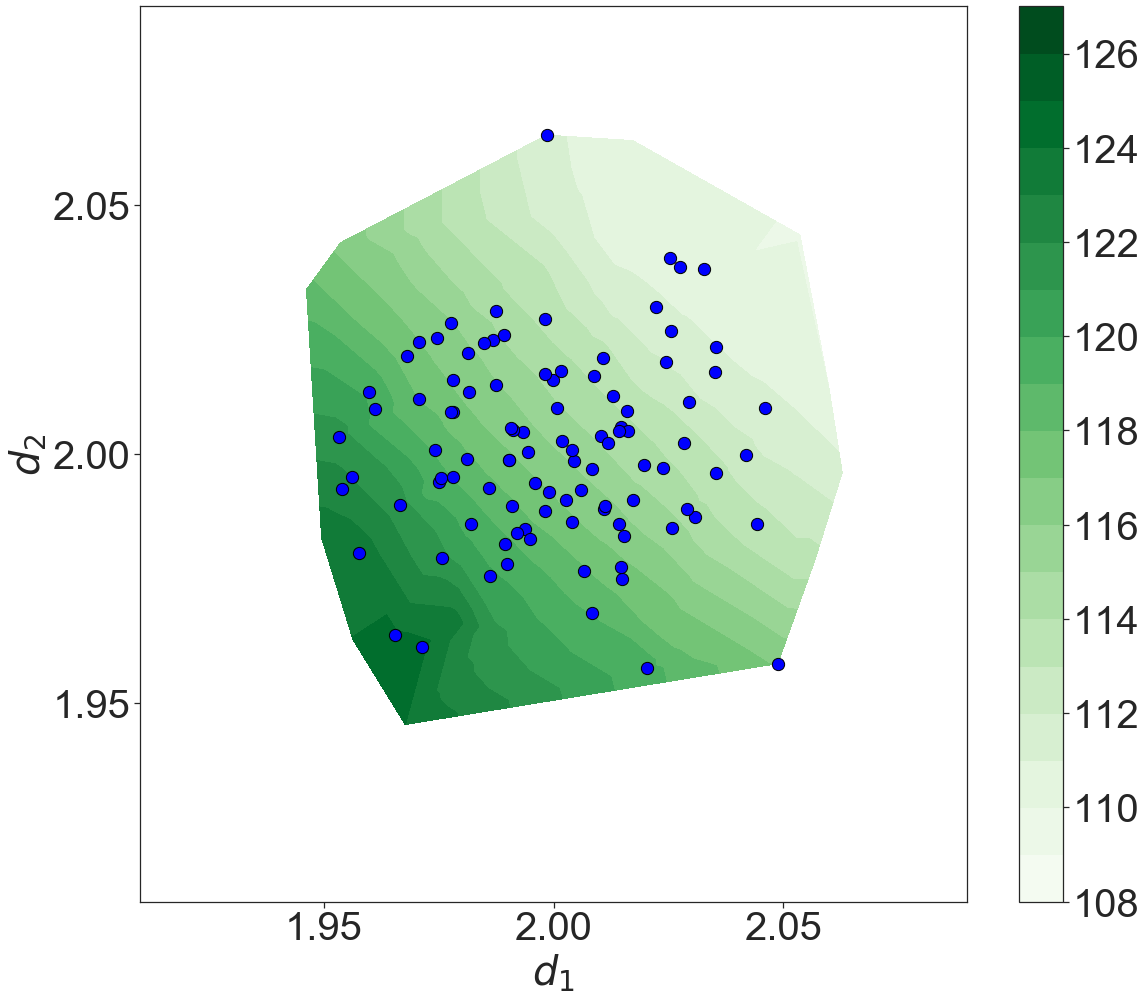

In [7]:
# plot predicted grafting barriers as a function of important coordinates

fig, axs = plt.subplots(1, 1, figsize=(16.5, 14), sharey=True)


# plot model predicted barriers vs d1 and d2
v = np.linspace(min(graft_E), max(graft_E), 20, endpoint=True)
sampled_local_coordinates = sampled_coordinates
tri2 = axs.tricontourf(local_coordinates[:,0], local_coordinates[:, 1], model_heights,v, cmap=cm.Greens)
axs.scatter(sampled_local_coordinates[0:n_samples,0], sampled_local_coordinates[0:n_samples,1], s=150, c='blue', edgecolors='black', label='Initial Pool')


# axes properties
axs.set_xlabel(r'$d_1$',fontsize='40')
axs.set_ylabel(r'$d_2$',fontsize='40')
axs.tick_params(labelsize='40')
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cb2 = fig.colorbar(tri2, ax=axs, format=ticker.EngFormatter(places=0))
cb2.ax.tick_params(labelsize=40)
tick_positions_x = [1.90, 1.95, 2.00, 2.05, 2.10]
axs.set_xticks(tick_positions_x)
axs.set_xticklabels([i for i in tick_positions_x])
tick_positions_y = [1.95, 2.00, 2.05, 2.10]
axs.set_yticks(tick_positions_y)
axs.set_yticklabels([i for i in tick_positions_y])
axs.tick_params(left='true', bottom='true')
axs.tick_params(axis = "x", labelsize=40)
axs.tick_params(axis = "y", labelsize=40)
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.set_xlim([1.91, 2.09])
axs.set_ylim([1.91, 2.09])

plt.tight_layout()
plt.show()
